<a href="https://colab.research.google.com/github/nhlakaniphom/Masters/blob/master/research_project_creditcardfraud_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A Data-Point Approach to Solving Imbalance 
Problem in Credit Card Fraud Dataset**

-- Student Number : 21349052

-- Nhlakanipho Michael Mqadi



In [0]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

In [0]:
# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

In [0]:
# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [0]:
from google.colab import files

In [0]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving creditcard.csv to creditcard.csv
User uploaded file "creditcard.csv" with length 150828752 bytes


In [0]:
data = pd.read_csv('creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [0]:
Exploratory Data Analysis

In [0]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

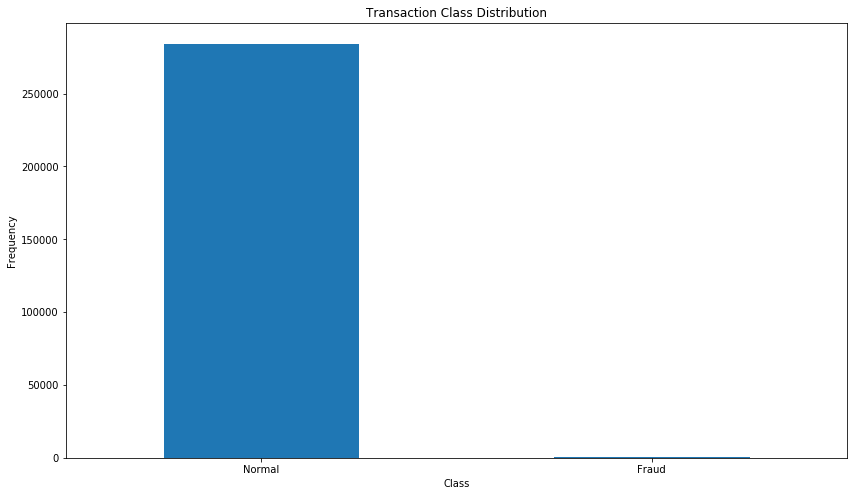

In [0]:

count_classes = pd.value_counts(data['Class'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

A dataset is imbalanced if at least one of the classes constitutes only a very small minority.

In [0]:

## Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [0]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [0]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [0]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

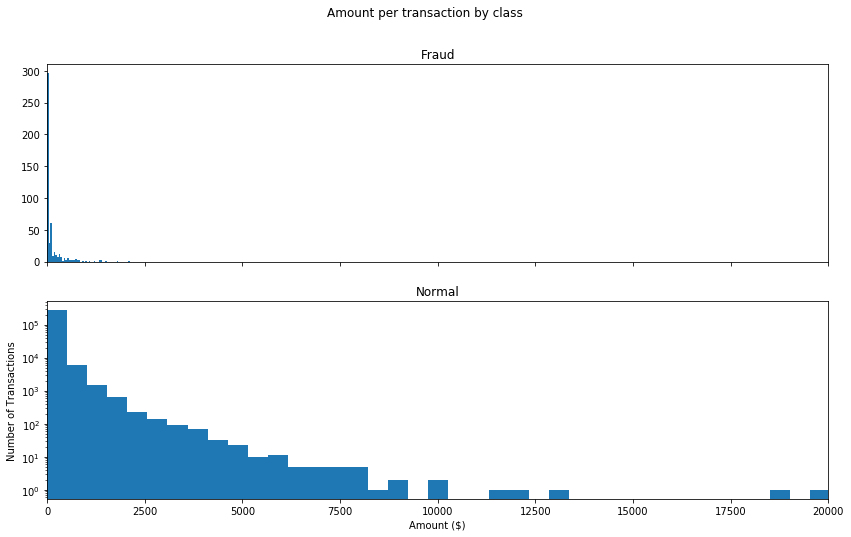

In [0]:

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

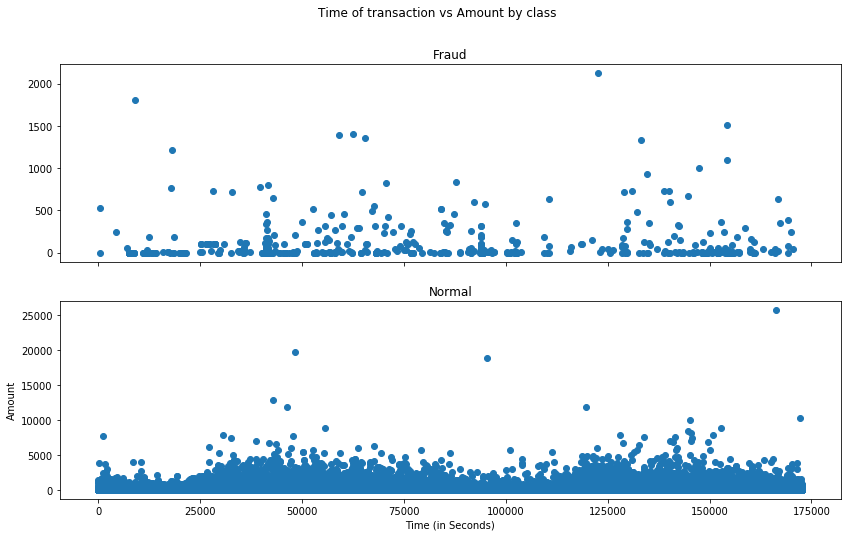

In [0]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [0]:
## Take some sample of the data

data1= data.sample(frac = 0.1,random_state=1)

data1.shape

(28481, 31)

In [0]:
data.shape

(284807, 31)

In [0]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['Class']==1]

Valid = data1[data1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [0]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017234102419808666
Fraud Cases : 49
Valid Cases : 28432


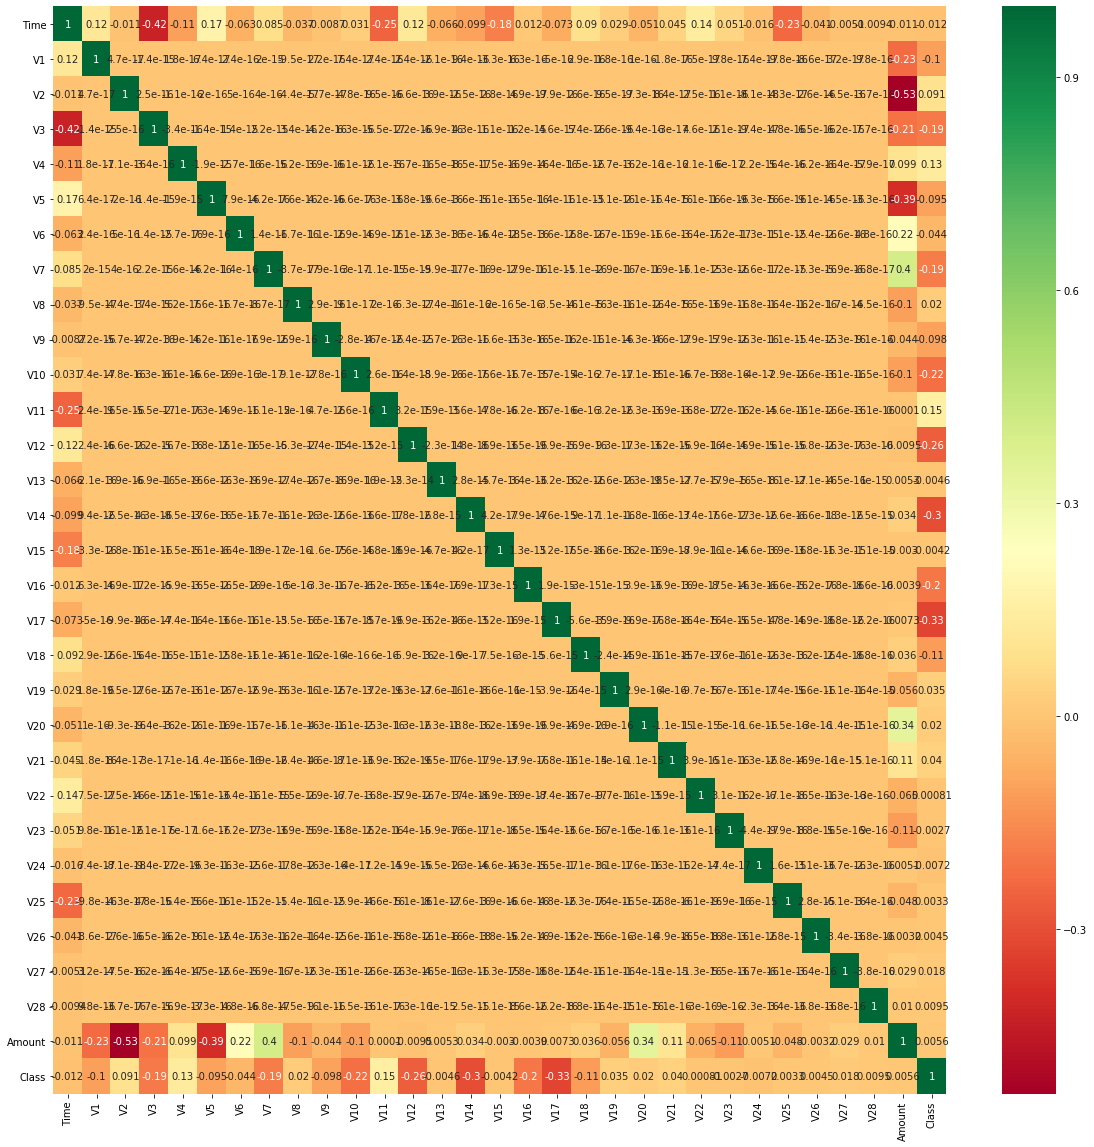

In [0]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

**Model Prediction**

Now it is time to start building the model .The types of algorithms we are going to use to try to do anomaly detection on this dataset are as follows:

**A Support Vector Machine (SVM)** 

It is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

**Logistic regression**

It is a statistical method for analysing a dataset in which there are one or more independent variables that determine an outcome. The outcome is measured with a dichotomous variable (in which there are only two possible outcomes). It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables.

**Decision Tree**

Tree based methods empower predictive models with high accuracy, stability and ease of interpretation. Unlike linear models, they map non-linear relationships quite well. They are adaptable at solving any kind of problem at hand (classification or regression). Decision Tree algorithms are referred to as CART (Classification and Regression Trees).

**Isolation Forest Algorithm :**

One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

**Local Outlier Factor(LOF) Algorithm**

The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [0]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state),
     "Logistic Regression":LogisticRegression()
     
}

In [0]:
type(classifiers)

dict

In [0]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    elif clf_name == "Logistic Regression":
        clf.fit(X,Y)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 73
Accuracy Score :
0.9974368877497279
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
Accuracy Score :
0.9965942207085425
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

Support Vector Machine: 8516
Accuracy Score :
0.7009936448860644
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.70   

**Observations :**

Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 errors

Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09 - the accuracy is not a true reflection of the model's ability to identify fruad. Precision & Recall is a measure I will use to analyze each model.

When comparing error, precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.

Further discussed below after the data-point approach has been used.





**The Data-Point Level Approach**

Oversampling and undersampling in data analysis are techniques used to adjust the class distribution of a data set (i.e. the ratio between the different classes/categories represented). These terms are used both in statistical sampling, survey design methodology and in machine learning.

In this initial iteration I will now use under-sampling - under-sampling technique is to under-sample the majority class randomly and uniformly.


In [0]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

In [0]:
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
X_res,y_res=smk.fit_sample(X,Y)

In [0]:
X_res.shape,y_res.shape

((55332, 30), (55332,))

Text(0, 0.5, 'Frequency')

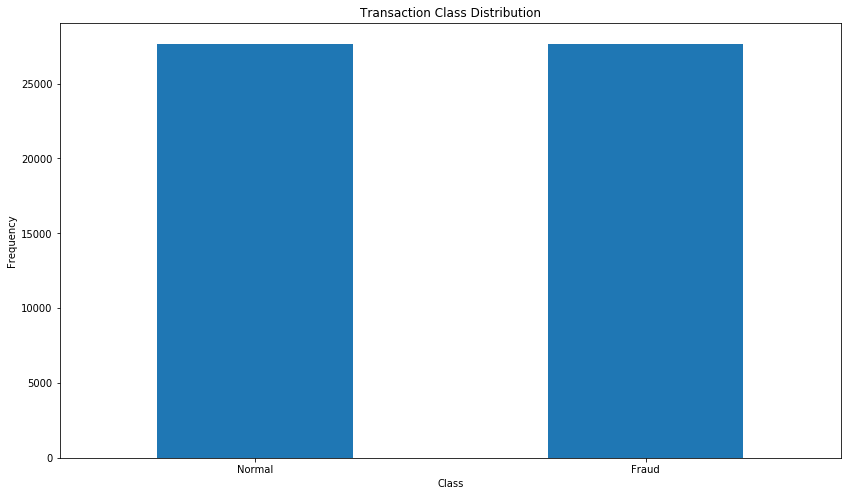

In [0]:
count_classes = pd.value_counts(y_res, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [0]:
## Get the Fraud and the normal dataset 

fraud = y_res[y_res==1]

normal = y_res[y_res==0]

In [0]:
print(fraud.shape,normal.shape)

(27666,) (27666,)


In [0]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 28432, 1: 49})
Resampled dataset shape Counter({0: 27666, 1: 27666})


In [0]:
## RandomOverSampler to handle imbalanced data

from imblearn.over_sampling import RandomOverSampler

In [0]:
os =  RandomOverSampler(ratio=0.5)

In [0]:
X_train_res, y_train_res = os.fit_sample(X, Y)

In [0]:
X_train_res.shape,y_train_res.shape

((42648, 30), (42648,))

Text(0, 0.5, 'Frequency')

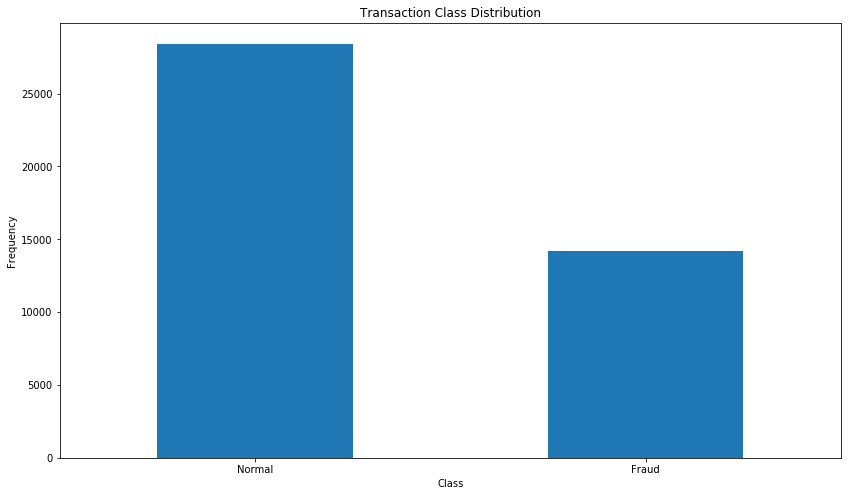

In [0]:
count_classes = pd.value_counts(y_train_res, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [0]:
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res)))

Original dataset shape Counter({0.0: 19424, 1.0: 43})
Resampled dataset shape Counter({0.0: 19424, 1.0: 9712})


In [0]:
# In this example I use SMOTETomek which is a method of imblearn. SMOTETomek is a hybrid method
# which uses an under sampling method (Tomek) in with an over sampling method (SMOTE).
os_us = SMOTETomek(ratio=0.5)

X_train_res1, y_train_res1 = os_us.fit_sample(X, Y)

In [0]:
X_train_res1.shape,y_train_res1.shape

((41254, 30), (41254,))

Text(0, 0.5, 'Frequency')

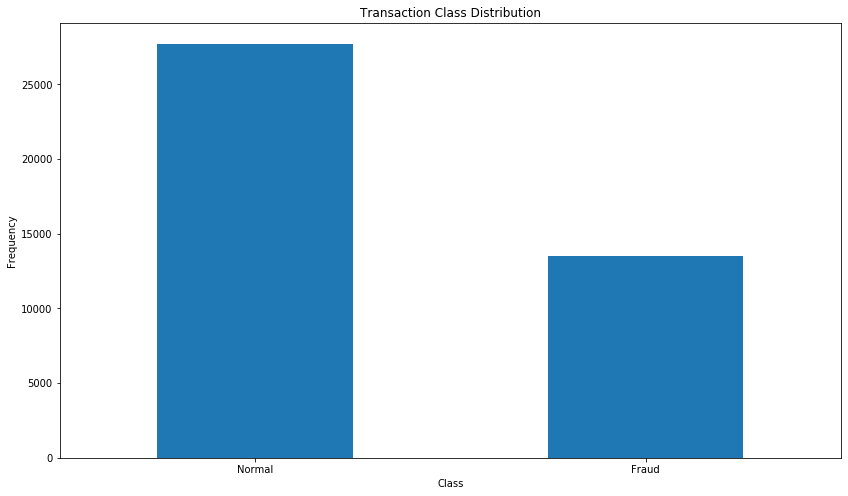

In [0]:
count_classes = pd.value_counts(y_train_res1, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [0]:
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_train_res1)))

Original dataset shape Counter({0: 28432, 1: 49})
Resampled dataset shape Counter({0: 27735, 1: 13519})


In [0]:
print(len(Y),len(y_train_res))

28481 42648


In [0]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X_train_res1), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state)
}

In [0]:
type(classifiers)

dict

In [0]:
n_outliers = len(fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X_res)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X_res)
        y_pred = clf.predict(X_res)
    elif clf_name == "Logistic Regression":
        clf.fit(X_res,y_res)
        y_pred = clf.predict(X_res)    
    else:    
        clf.fit(X_train_res1)
        scores_prediction = clf.decision_function(X_res)
        y_pred = clf.predict(X_res)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y_res).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y_res,y_pred))
    print("Classification Report :")
    print(classification_report(y_res,y_pred))

Isolation Forest: 27672
Accuracy Score :
0.4998915636521362
Classification Report :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     27666
           1       0.48      0.00      0.00     27666

    accuracy                           0.50     55332
   macro avg       0.49      0.50      0.34     55332
weighted avg       0.49      0.50      0.34     55332

Local Outlier Factor: 27740
Accuracy Score :
0.4986626183763464
Classification Report :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     27666
           1       0.11      0.00      0.00     27666

    accuracy                           0.50     55332
   macro avg       0.31      0.50      0.33     55332
weighted avg       0.31      0.50      0.33     55332

Support Vector Machine: 29091
Accuracy Score :
0.47424636738234655
Classification Report :
              precision    recall  f1-score   support

           0       0.47     

AttributeError: ignored

**Evaluation**

Accuracy is measured using the Area-Under the Precision-Recall Curve (AUPRC) to assert whether or not the accuracy has improved. 

**Precision:** is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value. Precision = TP / (TP + FP). 

**Recall:** is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive. The true positive rate is also referred to as sensitivity. Recall = TP / (TP + FN).

**F-Measure or F1 score:** is a composite score that attempt to summarize the precision and recall. F1 socre calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).


**Observations :**

In my proposal, I stated that I will use logistic regression, decision tree, and support vector machines (SVM). 

For this iteration I will discuss about the SVM findings.

**Precision** improved from **0% to 48%** - This data shows that if the data is highly imbalance, the model struggles to detect fruadulant transactions. After using under sampling which is a technique of the data-point approach. There was a signficate improvement in the ability to predict positive classes. 


**Recall** improved from **37% to 51%** - Recall describes how good the model is at predicting the positive class when the actual outcome is positive, therefore this show the strength of True Positive which are actual fraudulant cases. We saw a 14% improvement.

NOTE: The research is on-going and there is still plenty of reasearch required to identify the most suatable technique to handle highly imbalance data.